In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

import os
from os import listdir
from os.path import isfile, join
from collections import deque

import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
def norm_img(img):
    img = (img / 127.5) - 1
    return img
def load_images(data_dir, batch_size, image_shape):
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    
    sample_imgs_paths = [join(data_dir, f) for f in listdir(data_dir) if 'png' in f]
    sample_imgs_paths = sample_imgs_paths[:min(len(sample_imgs_paths), batch_size)]
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB')
        image = np.asarray(image)
#         image = norm_img(image)
        sample[index,...] = image
    return sample

def preocess_imge(images):
    images.astype('int8')
    images /= 255.
#     images[images  >= .5] = 1.
#     images[images < .5] = 0.
    return images
def get_batch_image(images, batch_size, IMAGE_SHAPE):
#     np.random.shuffle(images)
    return [images[i*batch_size : (i+1) *batch_size] for i in range(images.shape[0] // batch_size)]

IMAGE_SHAPE = (512, 512, 3)
data_dir = './input_high/'
BATCH_SIZE = 10
train_images = preocess_imge(load_images(data_dir, BATCH_SIZE, IMAGE_SHAPE))
test_images = preocess_imge(load_images(data_dir, BATCH_SIZE, IMAGE_SHAPE))[:4]

(10, 512, 512, 3)

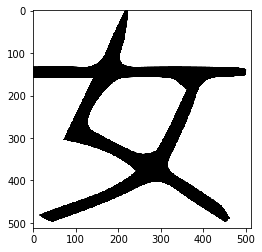

In [3]:
plt.imshow(train_images[0])
train_images.shape

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # 512, 512, 3
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[512, 512, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 256, 256, 64
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 128, 128, 128
    model.add(layers.Conv2D(256, (2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 64, 64, 256
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
def discriminator_loss(real_output, fake_output, gen_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    gen_loss = cross_entropy(tf.zeros_like(gen_output), fake_output)
    total_loss = real_loss + fake_loss + gen_loss
    return total_loss
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [5]:
def make_encoder(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(512, 512, 3)))
    model.add(layers.Conv2D(filters=32, kernel_size=3, strides=(4, 4), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(latent_dim + latent_dim))
    return model

def make_decoder(latent_dim):
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*32, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((32, 32, 32)))
    
    model.add(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(4, 4), padding="SAME", activation='relu'))
    # 128, 128, 64
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    # 256, 256, 32
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    # 512, 512, 16
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation='relu'))
    # 512, 512, 3
    return model

@tf.function
def sample(decoder, test_input, eps=None):
    latent_dim = 50
    if eps is None:
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(decoder, test_input, apply_sigmoid=True)

def encode(encoder, x):
    mean, logvar = tf.split(encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

In [6]:
latent_dim = 50
num_examples_to_generate = 1

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

discriminator = make_discriminator_model()
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

encoder = make_encoder(latent_dim)
encoder_optimizer = tf.keras.optimizers.Adam(1e-4)

decoder = make_decoder(latent_dim)
decoder_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
print(random_vector_for_generation.shape)
decoder.summary()
# sample(decoder, latent_dim)
# decoder(random_vector_for_generation)

(1, 50)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              409600    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 

In [8]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
          -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

@tf.function
def gen_from_vae(encoder, decoder, x):
    mean, logvar = encode(encoder, x)
    z = reparameterize(mean, logvar)
    x_gen = decode(decoder, z)
    return x_gen, mean, logvar, z

@tf.function
def get_recon_loss(recon, source):
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=recon, labels=source)
    return tf.reduce_mean(tf.reduce_sum(cross_ent, axis=[1, 2, 3]))

@tf.function
def get_encode_loss(recon, source, mean, logvar, z):
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=recon, labels=source)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def kl_loss(encoder, decoder, x):
    mean, logvar = encode(encoder, x)
    z = reparameterize(mean, logvar)
    x_logit = decode(decoder, z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(source_images, noise_dim, batch_size):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as encoder_tape, tf.GradientTape() as decoder_tape, tf.GradientTape() as disc_tape:
        recon_images, mean, logvar, z = gen_from_vae(encoder, decoder, source_images)
        generated_images = decode(decoder, noise)

        real_output = discriminator(source_images, training=True)
        gen_output = discriminator(recon_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        encode_loss = get_encode_loss(recon_images, source_images, mean, logvar, z)
        decode_loss = get_recon_loss(recon_images, source_images) + \
                        generator_loss(gen_output) + generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, gen_output)

    gradients_of_encoder = encoder_tape.gradient(encode_loss, encoder.trainable_variables)
    gradients_of_decoder = decoder_tape.gradient(decode_loss, decoder.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
    decoder_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
def generate_and_save_images(output_dir, epoch, test_input):
    predictions = sample(decoder, test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(1):
        plt.subplot(1, 1, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}image_at_epoch_{:04d}.png'.format(output_dir, epoch))
    plt.show()

In [10]:
output_dir = './output/'

In [20]:
epochs = 2000
batch_size = 4
begin = 2481

Epoch: 3200, Test set ELBO: 316581.78125, time elapse for current epoch 11.329894781112671


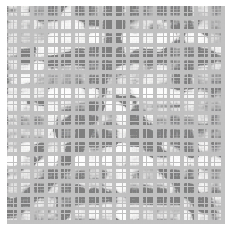

KeyboardInterrupt: 

In [21]:
generate_and_save_images(output_dir, 0, random_vector_for_generation)

for epoch in range(begin, epochs + begin):
    start_time = time.time()
    image_batches = get_batch_image(train_images, batch_size, IMAGE_SHAPE)
    for train_x in image_batches:
        train_step(train_x, latent_dim, batch_size)
    end_time = time.time()

    if epoch % 20 == 0:
        loss = tf.keras.metrics.Mean()
        loss(kl_loss(encoder, decoder, test_images))
        elbo = loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
        generate_and_save_images(
            output_dir, epoch, random_vector_for_generation)

In [22]:
encoder.save('./model/encoder_black_8.h5') 
discriminator.save('./model/discriminator_black_8.h5') 
decoder.save('./model/decoder_black_8.h5') 

(1, 50)
(1, 512, 512, 3)
10


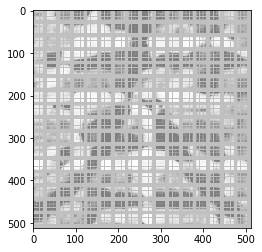

In [17]:
print(random_vector_for_generation.shape)
predictions = sample(decoder, random_vector_for_generation)
print(predictions.shape)
print(len(train_images))
plt.imshow(predictions[0, :, :, :])

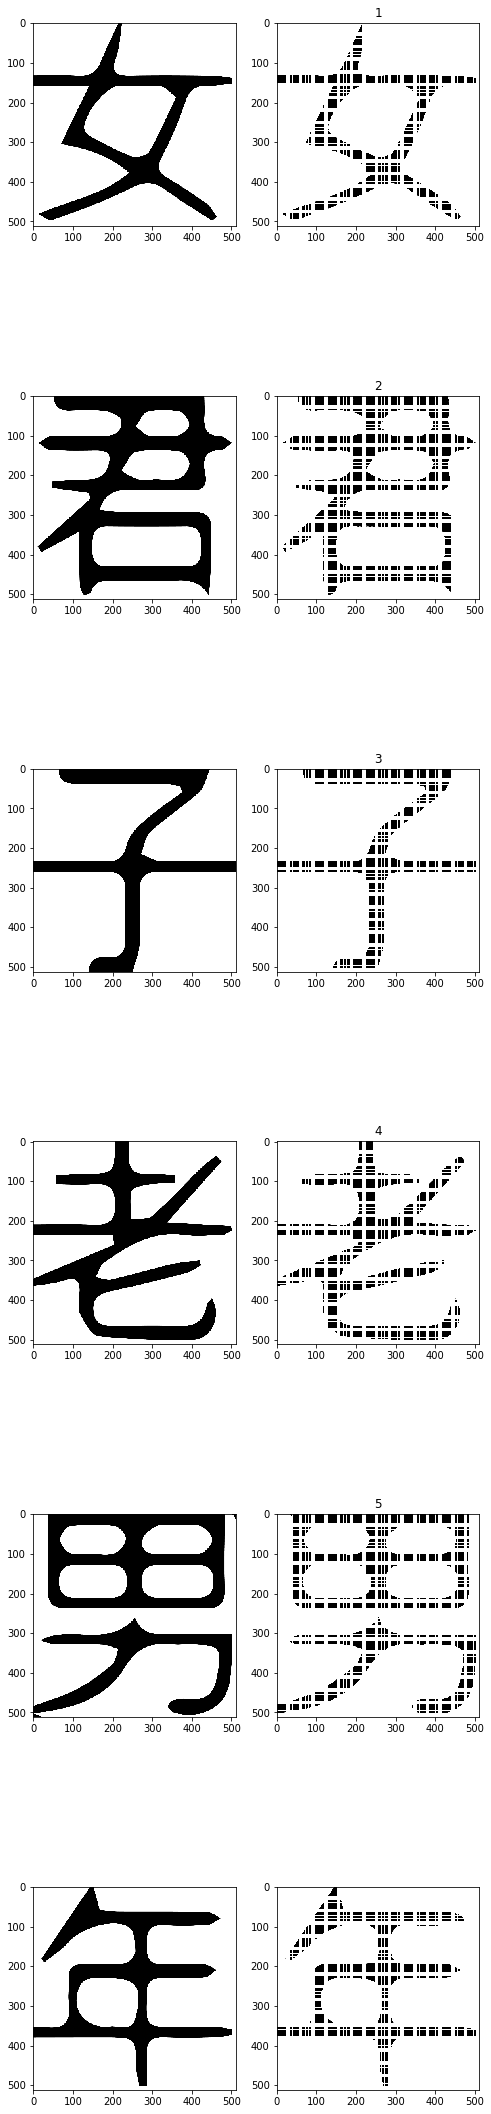

In [23]:
def to_grey(rgb):
     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

plt.figure(figsize=(8,40))
for i, input_img in enumerate(train_images):
    k = 5
    x = train_images[i:i+1]
    mean, logvar = encode(encoder, x)
    z = reparameterize(mean, logvar)
    gen_imge = decode(decoder, z)
    plt.title(str(i))
    plt.subplot(k+1, 2, 2*i+1)
    plt.imshow(x[0,:,:,:])
    plt.subplot(k+1, 2, 2*i+2)
    plt.imshow(to_grey(gen_imge[0,:,:,:]), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    if i == k:
        break

In [24]:
def get_diff_vector(x, y):
    mean, logvar = encode(encoder, x)
    z1 = reparameterize(mean, logvar)
    
    mean, logvar = encode(encoder, y)
    z2 = reparameterize(mean, logvar)
    return z2- z1

def change_from(source, target, step):
    output_dir = './moving_output/'
    mean, logvar = encode(encoder, source)
    z = reparameterize(mean, logvar)
    
    w = get_diff_vector(source, target)
    
    fig = plt.figure(figsize=(5, 5))
    for i in range(2 * step):
        if i < step:
            z += (1.0 / step) * w
        else:
            z -= (1.0 / step) * w
        gen_imge = decode(decoder, z)
        plt.imshow(to_grey(gen_imge[0,:,:,:]), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
        plt.savefig('{}image_at_epoch_{}.png'.format(output_dir, str(i)))


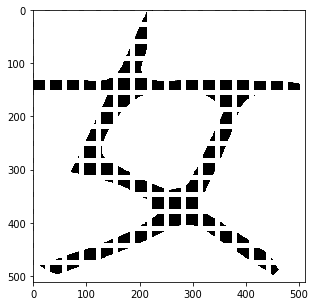

In [27]:
import warnings
warnings.filterwarnings("ignore")

source, target = train_images[0:1], train_images[1:2]
change_from(source, target, 100)

In [28]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [29]:
anim_file = 'cvae_girl_men.gif'
output_dir = './moving_output/'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}*.png'.format(output_dir))
    filenames = sorted(filenames, key = lambda x : int(x.replace('.png', '').split('_')[-1]))
    last = -1
    for i,filename in enumerate(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)